## Importing the necessary libraries

In [1116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, VotingClassifier
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
import pickle

import warnings
warnings.filterwarnings("ignore")

### DATA WRANGLING AND EXPLORATORY ANALYSIS

In [1119]:
def wrangle(file_path):
    df = pd.read_csv(file_path)
    mask_r = df.rainfall < 220
    mask_n = df.N <= 110
    mask_k,mask_p = (df.K <= 110),(df.P <= 110)
    df = df[mask_r & mask_n & mask_k & mask_p]
    return df

In [1120]:
df = wrangle("Crop_recommendation.csv")

In [1122]:
print(f"The shape of my data is : {df.shape}")

The shape of my data is : (1745, 8)


In [1123]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
13,93,56,36,24.014976,82.056872,6.984354,185.277339,rice
14,94,50,37,25.665852,80.663850,6.948020,209.586971,rice
17,91,35,39,23.793920,80.418180,6.970860,206.261186,rice
20,89,45,36,21.325042,80.474764,6.442475,185.497473,rice


In [1125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1745 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            1745 non-null   int64  
 1   P            1745 non-null   int64  
 2   K            1745 non-null   int64  
 3   temperature  1745 non-null   float64
 4   humidity     1745 non-null   float64
 5   ph           1745 non-null   float64
 6   rainfall     1745 non-null   float64
 7   label        1745 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 122.7+ KB


In [1126]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [1127]:
df.duplicated().sum()

0

In [1128]:
df.label.unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'watermelon', 'muskmelon', 'orange', 'papaya',
       'coconut', 'cotton', 'jute', 'coffee'], dtype=object)

In [1129]:
#  Statistical Summary of the data
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000
mean,46.279656,45.846418,32.422923,25.899964,68.297200,6.513109,99.446205
std,32.979260,22.330283,17.278909,4.973108,23.592695,0.810817,48.993493
min,0.000000,5.000000,5.000000,10.010813,14.258040,3.504752,20.211267
25%,20.000000,25.000000,19.000000,23.086593,54.439451,6.010392,61.192509
50%,36.000000,48.000000,26.000000,26.105512,72.854628,6.497367,94.112133
75%,79.000000,64.000000,44.000000,28.880789,89.127604,6.978362,124.611847
max,110.000000,95.000000,85.000000,43.675493,99.981876,9.935091,219.904835


### Visualisation of data

In [1131]:
#Checking for the most used nutrients by the plants

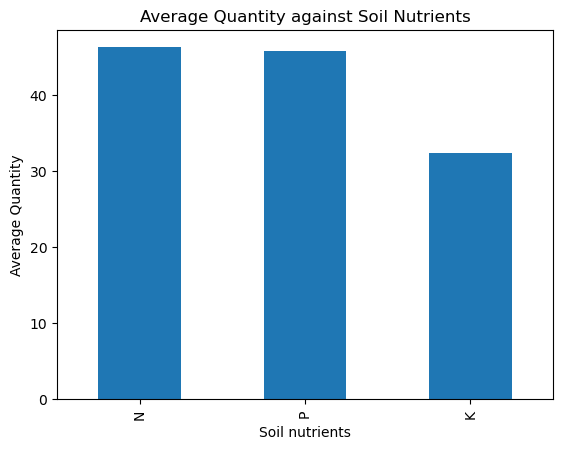

In [1133]:
df[["N","P","K"]].mean().plot(kind="bar")
plt.xlabel("Soil nutrients")
plt.ylabel("Average Quantity")
plt.title("Average Quantity against Soil Nutrients");

In [1134]:
#This shows that Potassium is less needed

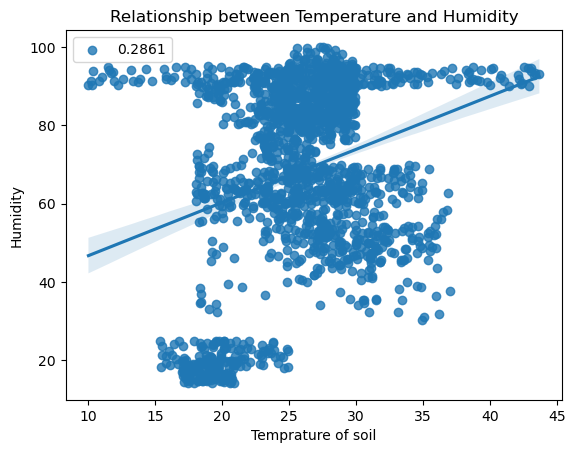

In [1135]:
label = df["temperature"].corr(df["humidity"]).round(4)
sns.regplot(data=df,x="temperature",y="humidity",label=label)
plt.legend()
plt.xlabel("Temprature of soil")
plt.ylabel("Humidity")
plt.title("Relationship between Temperature and Humidity");

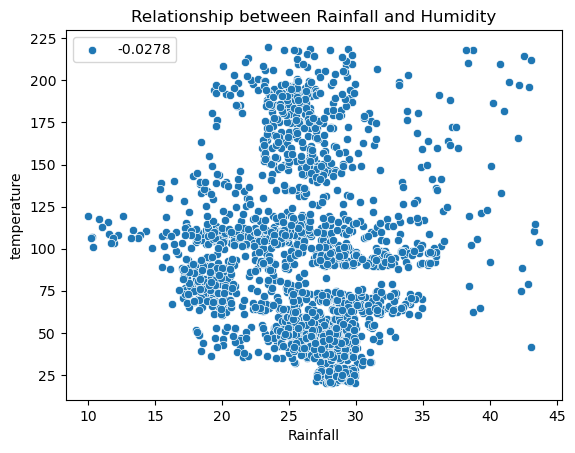

In [1136]:
label = df["temperature"].corr(df["rainfall"]).round(4)
sns.scatterplot(data=df,x="temperature",y="rainfall",label=label)
plt.legend()
plt.xlabel("Rainfall")
plt.ylabel("temperature")
plt.title("Relationship between Rainfall and Humidity");

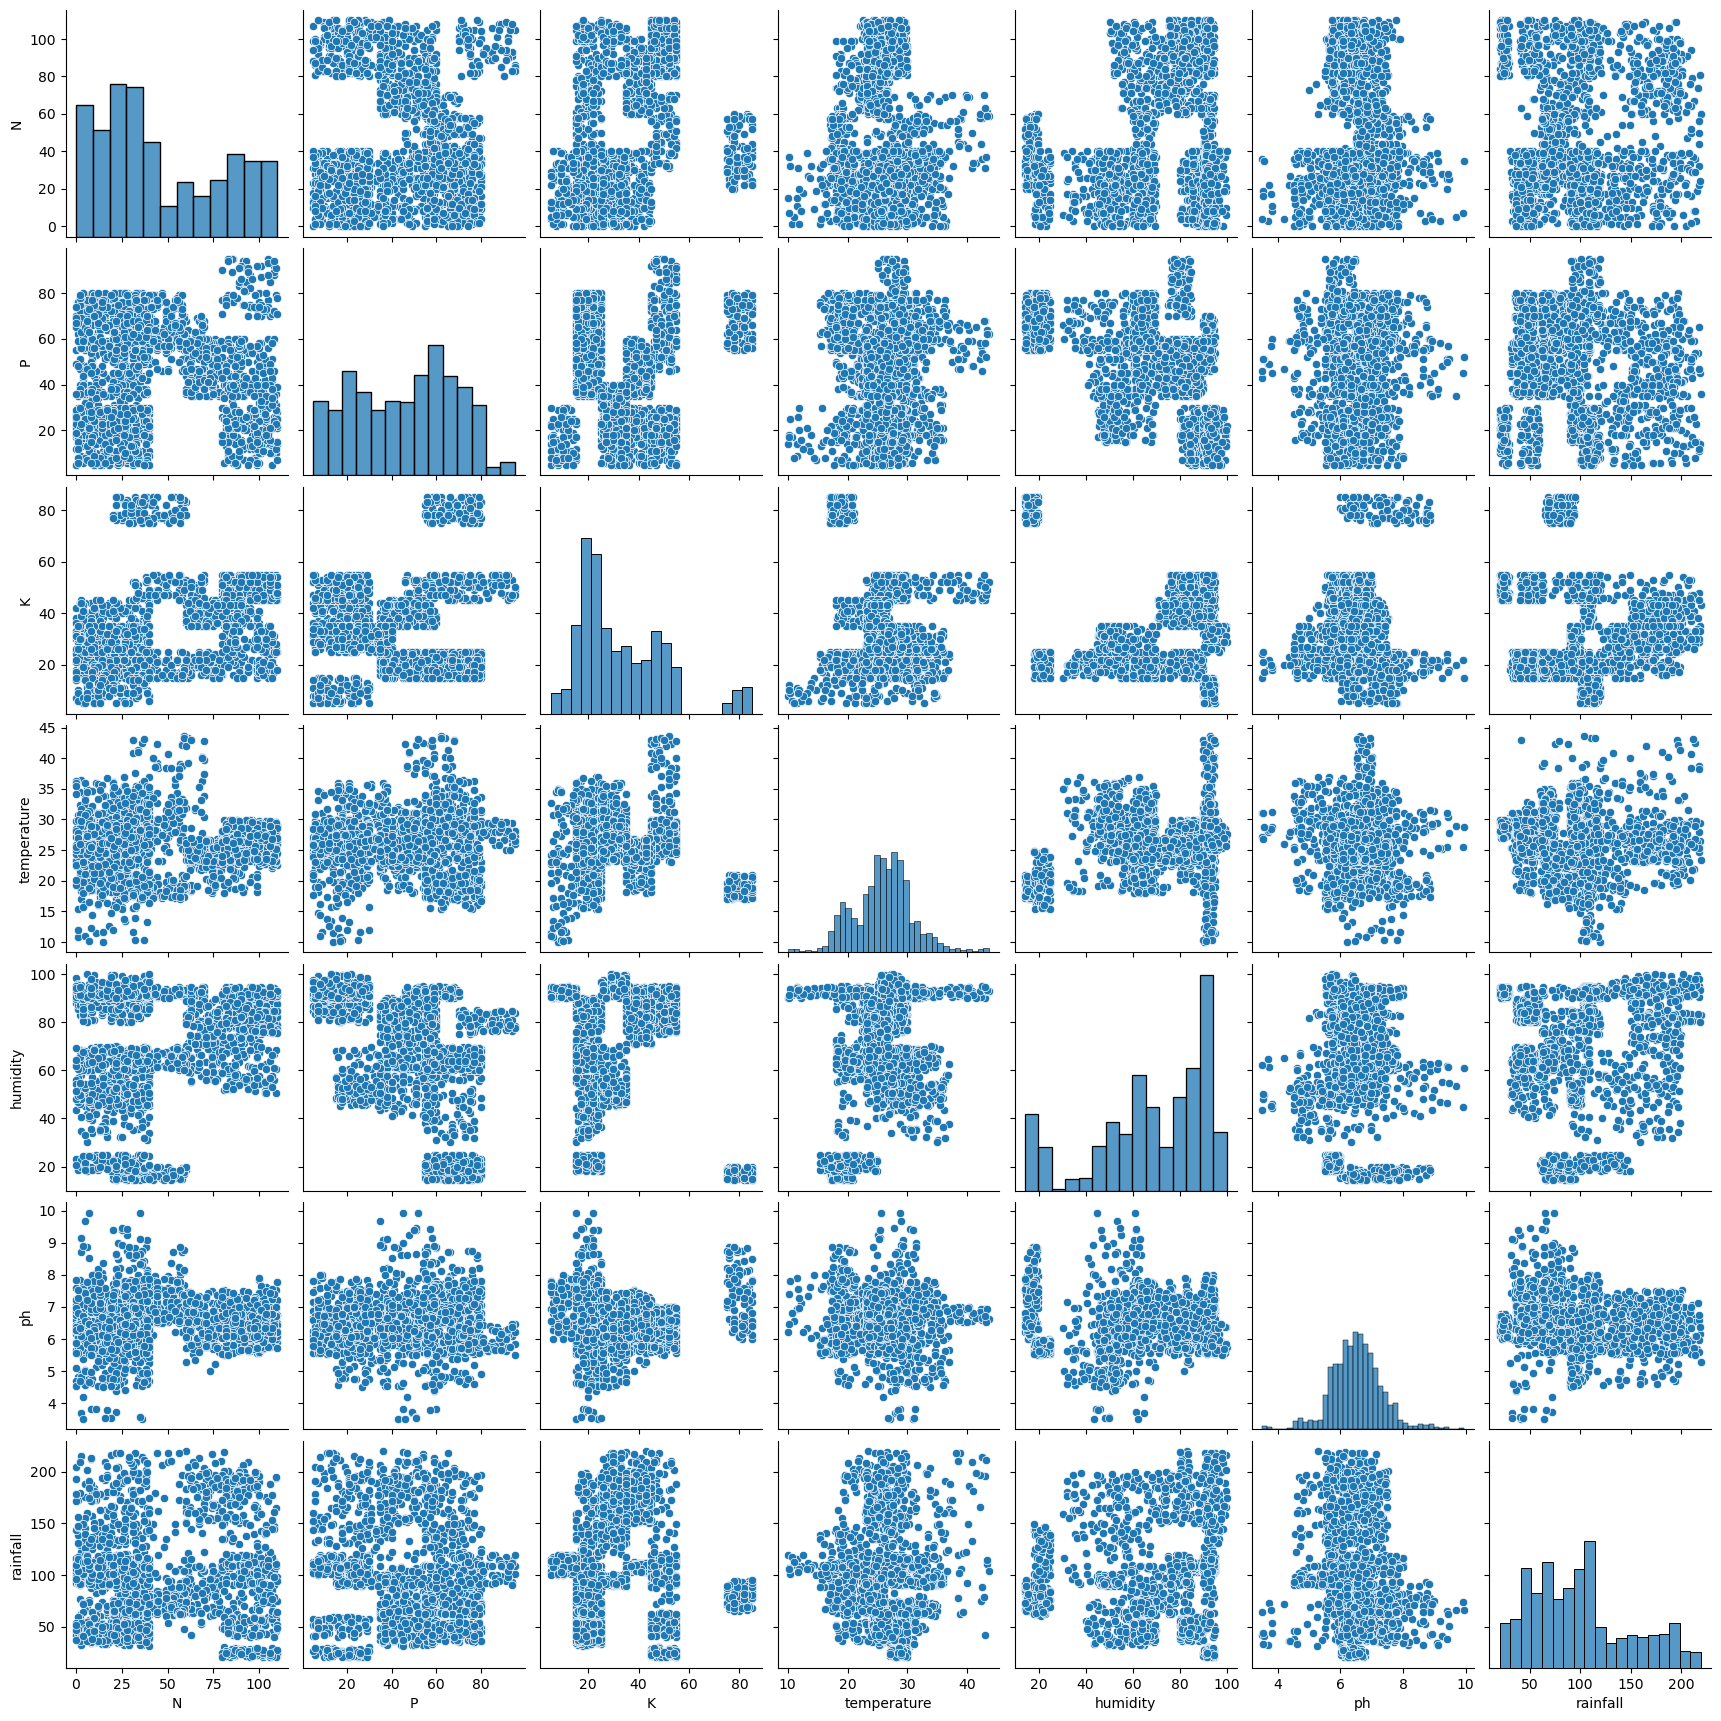

In [1137]:
sns.pairplot(df.select_dtypes(exclude="object"))

##### From the pair plot, the relationship between the P and the K histograms 
##### shows that they contains outliers hence they require cleaning

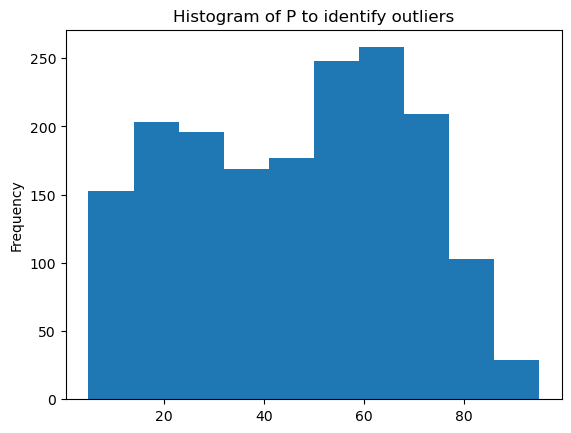

In [1139]:
df.P.plot(kind='hist')
plt.title("Histogram of P to identify outliers");

In [1140]:
#Hence from values 110 and above considered outliers

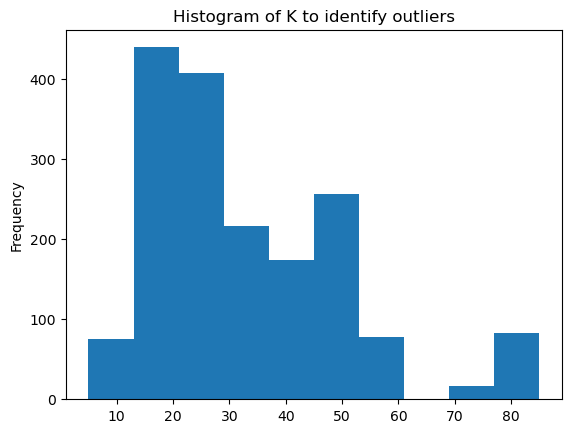

In [1141]:
df.K.plot(kind='hist')
plt.title("Histogram of K to identify outliers");

### Feature Engineering

In [1143]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [1144]:
#From the summary rainfall and K has higher margin between the 100% and 75% percentile

Maximum K: 85


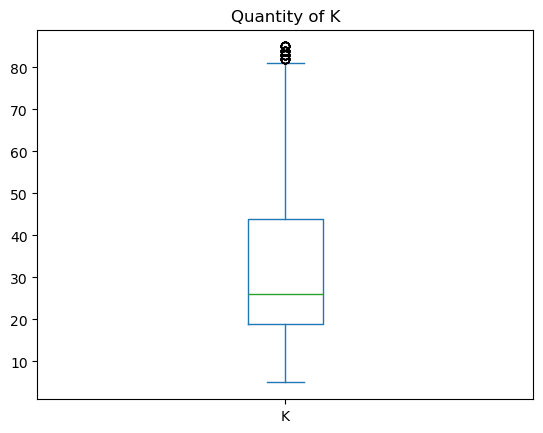

In [1146]:
plt.grid(visible=True)
df["K"].plot(kind="box")
plt.title("Quantity of K");
print(f"Maximum K: {df.K.max()}")

In [1149]:
Kq1,Kq3 = df.K.quantile([0.1,0.75]) #Using the IQR method

In [1150]:
KIQ = (Kq3-Kq1)

In [1151]:
lower_qk, high_qk = (KIQ - Kq1*1.5),(Kq3*1.5 + KIQ)

In [1152]:
df.N.max(),high_qk

(110, 94.0)

Maximum rainfall: 219.9048349


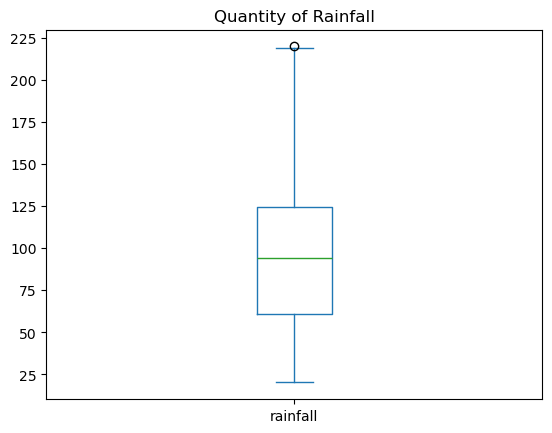

In [1153]:
plt.grid(visible=True)
df["rainfall"].plot(kind="box")
plt.title("Quantity of Rainfall");
print(f"Maximum rainfall: {df.rainfall.max()}")

### Model Building

In [1156]:
#Splitting data into features and target

In [1159]:
X = df.drop("label",axis=1)
y = df.label

The baseline score of the dataset is : 0.057


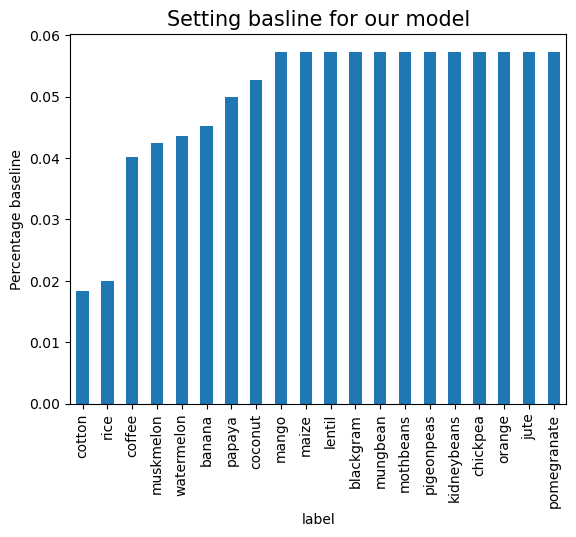

In [1232]:
#Set a baseline score for the model
y.value_counts(normalize=True).sort_values().plot(kind="bar")
plt.title("Setting basline for our model",fontsize=15)
plt.ylabel("Percentage baseline")
baseline  = round(y.value_counts(normalize=True).max(),3)
print(f"The baseline score of the dataset is : {baseline}")

In [1162]:
#Splitting the data into training,validation and testing

In [1164]:
X_temp,X_train,y_temp,y_train = train_test_split(X,y,test_size=0.5,random_state=42)

In [1165]:
print(f"X_temp size : {X_temp.shape}")
print(f"y_temp size : {y_temp.shape}")
print(f"X_train size : {X_train.shape}")
print(f"y_train size : {y_train.shape}")

X_temp size : (872, 7)
y_temp size : (872,)
X_train size : (873, 7)
y_train size : (873,)


In [1167]:
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [1170]:
print(f"X_val size : {X_val.shape}")
print(f"y_val size : {y_val.shape}")
print(f"X_test size : {X_test.shape}")
print(f"y_test size : {y_test.shape}")

X_val size : (436, 7)
y_val size : (436,)
X_test size : (436, 7)
y_test size : (436,)


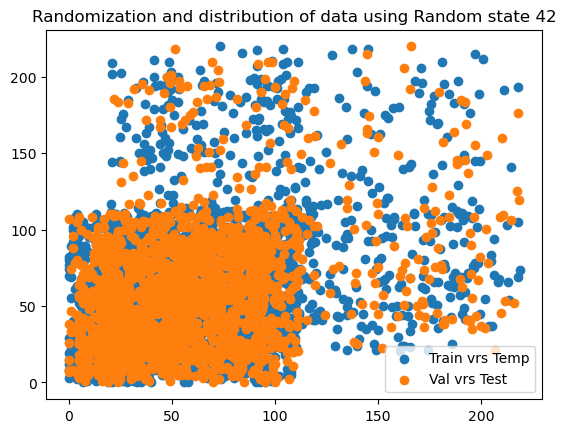

In [1171]:
#Furthure split to form validation and testing datasets
plt.scatter(x=X_train[:870],y=X_temp[:870],label="Train vrs Temp")
plt.scatter(x=X_val[:436],y=X_test[:436],label="Val vrs Test")
plt.legend()
plt.title("Randomization and distribution of data using Random state 42");

#### preprocessing data using transformer and Creating pipeline

In [1173]:
#numerical columns
num_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

In [1175]:
#Preprocessing the numerical columns
numerical_pipe = Pipeline(steps=[
    ("impute",SimpleImputer(strategy="median")),
    ("scale",MinMaxScaler())
])

#Transforming the numerical columns
transformer = ColumnTransformer(transformers=[
    ("num_pipe",numerical_pipe,num_columns)
],
    remainder='drop',
    n_jobs=-1
)

#### Training a Gradient Boosting model and a Random Forest model

In [1177]:
model1 = make_pipeline(transformer,GradientBoostingClassifier())

In [1178]:
model2 = make_pipeline(transformer,RandomForestClassifier())

In [1179]:
model1.fit(X_train,y_train) #Fitting the Gradient Boosting model for training

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [1180]:
#Checking the score of the GBC model performance using the validation data

In [1181]:
model1.score(X_val,y_val)

0.9678899082568807

In [1182]:
model2.fit(X_train,y_train) #Fitting the Random Tree model for training


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['N', 'P', 'K', 'temperature',
                                                   'humidity', 'ph',
                                                   'rainfall'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [1183]:
model2.score(X_val,y_val) #Checking the score of the RTC model performance using the validation data

1.0

In [1184]:
#From the above models it shows that the RandomForestClassifier performs better

#### Evaluating the model performance using some metrics

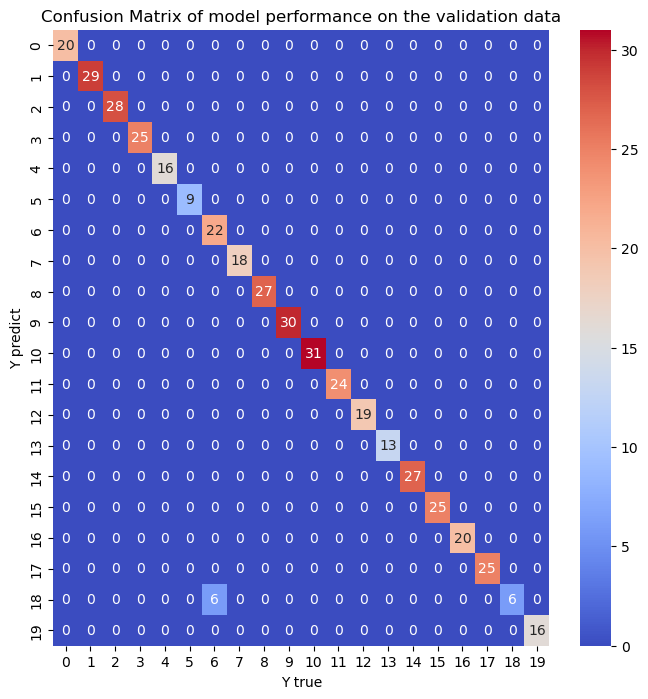

In [1186]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,model2.predict(X_test)),annot=True,cmap='coolwarm')
plt.title("Confusion Matrix of model performance on the validation data")
plt.xlabel("Y true")
plt.ylabel("Y predict");

In [1187]:
#Checking for the entire classification report of the model

In [1188]:
print(classification_report(y_test,model2.predict(X_test)))

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        29
    chickpea       1.00      1.00      1.00        28
     coconut       1.00      1.00      1.00        25
      coffee       1.00      1.00      1.00        16
      cotton       1.00      1.00      1.00         9
        jute       0.79      1.00      0.88        22
 kidneybeans       1.00      1.00      1.00        18
      lentil       1.00      1.00      1.00        27
       maize       1.00      1.00      1.00        30
       mango       1.00      1.00      1.00        31
   mothbeans       1.00      1.00      1.00        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        13
      orange       1.00      1.00      1.00        27
      papaya       1.00      1.00      1.00        25
  pigeonpeas       1.00      1.00      1.00        20
 pomegranate       1.00    

### Communicating results

In [1191]:
features = model2.feature_names_in_
feature_importances = model2.named_steps['randomforestclassifier'].feature_importances_

In [1192]:
feat_imp = pd.Series(feature_importances,index=features)

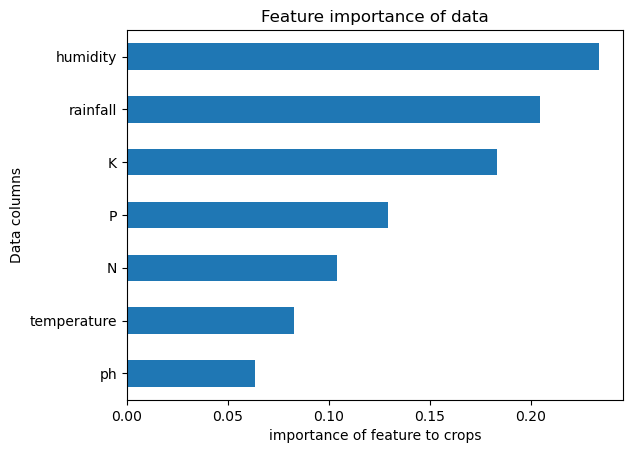

In [1193]:
#Plot a horizontal bar graph for the representation
feat_imp.sort_values().plot(
    kind="barh",
    title="Feature importance of data",
    ylabel="Data columns",
    xlabel="importance of feature to crops"
);

### Saving the Testing data and the model for production

In [1195]:
X_test.to_csv("crop_reccomend_test.csv")

In [1196]:
with open("crop_recommendation.pkl","wb") as file:
    pickle.dump(model2,file)

### testing the model

In [1198]:
def testingModel(filepath,modelpath):
    X_test_set = wrangle(filepath)
    with open(modelpath,"rb") as file:
        model = pickle.load(file)
    pred = model.predict(X_test_set)
    return pred

In [1199]:
result = testingModel("crop_reccomend_test.csv",
                      "crop_recommendation.pkl"
                     )

In [1200]:
result[:3]

array(['lentil', 'chickpea', 'mango'], dtype=object)

In [1201]:
y_test[:3]

840       lentil
256     chickpea
1156       mango
Name: label, dtype: object

# ...